In [1]:
import os
import glob
from datetime import datetime
from datetime import timezone
import polars as pl
import matplotlib.pyplot as plt
from sklearn import linear_model
import numpy as np
import math
from sklearn.metrics import r2_score
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go


# start_date = datetime(2023, 11, 17, 0, 0, 0).replace(tzinfo=timezone.utc)
# end_date = datetime(2023, 11, 28, 15, 59, 59).replace(tzinfo=timezone.utc)
# system_ids = [18]

#start_date = datetime(2023, 12, 22, 15, 0, 0).replace(tzinfo=timezone.utc)
#start_date = datetime(2024, 1, 12, 20, 0, 0).replace(tzinfo=timezone.utc)
start_date = datetime(2024, 1, 17, 0, 0, 0).replace(tzinfo=timezone.utc)
end_date = datetime(2024, 1, 30, 23, 59, 59).replace(tzinfo=timezone.utc)
system_ids = [3,6,10,11,12,13,16,18,20]

filter = '1h'

DATA_DIRECTORY = os.environ.get("DATA_DIRECTORY")
PICARRO_DATA_DIRECTORy = os.environ.get("PICARRO_DATA_DIRECTORY")


In [2]:
def rmse(y_true, y_meas):
    MSE = np.square(np.subtract(y_true, y_meas)).mean()
    RMSE = math.sqrt(MSE)

    return RMSE

def calc_r2(y_true, y_meas):
    return r2_score(y_true, y_meas)

In [3]:
df_cal = pl.scan_parquet(os.path.join(DATA_DIRECTORY, "processed", "slope_intercept_acropolis.parquet")) \
    .with_columns((pl.col("creation_timestamp").dt.timestamp("ms") / 3.6e6).alias("timestamp")) #3.6e6 ms are in 1h

# Perform RANSAC only on slope and then select valid calibrations

In [4]:
def fit_ransac(x, y, date):
    #x = range(len(y))

    Y = np.array(y)
    X = np.array(x)
    T = np.array(date)

    # Robustly fit linear model with RANSAC algorithm
    ransac = linear_model.RANSACRegressor(residual_threshold=0.01)
    ransac.fit(X.reshape(-1, 1), Y)
    inlier_mask = ransac.inlier_mask_
    outlier_mask = np.logical_not(inlier_mask)
    line_X = np.arange(X.min(), X.max())[:, np.newaxis]
    line_y_ransac = ransac.predict(line_X)
    
    # plot
    lw = 2
    
    plt.scatter(
        X[inlier_mask], Y[inlier_mask], color="yellowgreen", marker=".", label="Inliers"
    )
    plt.scatter(
        X[outlier_mask], Y[outlier_mask], color="gold", marker=".", label="Outliers"
    )
    plt.plot(
        line_X,
        line_y_ransac,
        color="cornflowerblue",
        linewidth=lw,
        label="RANSAC regressor",
    )
    plt.legend()
    plt.xlabel("Unix Time (h)")
    plt.ylabel(f"slope for system: {id}")
    plt.show()
    #----
    
    return inlier_mask

In [5]:
df_cal.filter(pl.col("system_name") == f"tum-esm-midcost-raspi-12").filter(pl.col("creation_timestamp").is_between(start_date, end_date)).collect()

date,system_name,slope,intercept,creation_timestamp,timestamp
date,str,f64,f64,"datetime[μs, UTC]",f64
2024-01-17,"""tum-esm-midcos…",1.039244,1.409429,2024-01-17 03:32:04.600 UTC,473739.534611
2024-01-18,"""tum-esm-midcos…",1.031998,4.489372,2024-01-18 03:21:05.120 UTC,473763.351422
2024-01-19,"""tum-esm-midcos…",1.016422,10.50455,2024-01-19 03:31:20.420 UTC,473787.522339
2024-01-20,"""tum-esm-midcos…",1.035627,1.352496,2024-01-20 03:13:24.280 UTC,473811.223411
2024-01-21,"""tum-esm-midcos…",1.038523,0.251919,2024-01-21 03:30:46.600 UTC,473835.512944
2024-01-22,"""tum-esm-midcos…",1.035553,1.296931,2024-01-22 03:17:43.560 UTC,473859.295433
2024-01-23,"""tum-esm-midcos…",1.046915,-2.699616,2024-01-23 03:31:45.010 UTC,473883.529169
2024-01-24,"""tum-esm-midcos…",1.038587,0.846689,2024-01-24 03:20:39.280 UTC,473907.344244
2024-01-25,"""tum-esm-midcos…",1.04819,-1.920181,2024-01-25 03:31:37 UTC,473931.526944


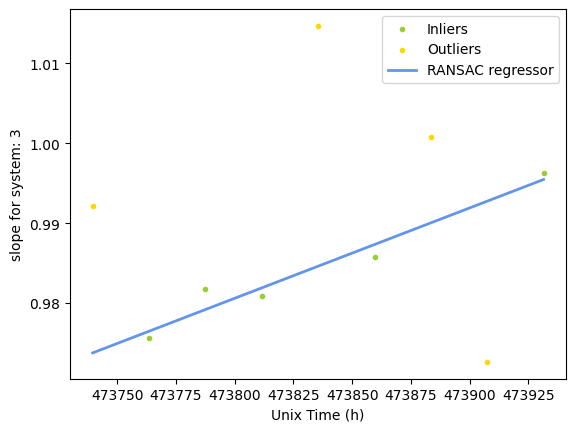

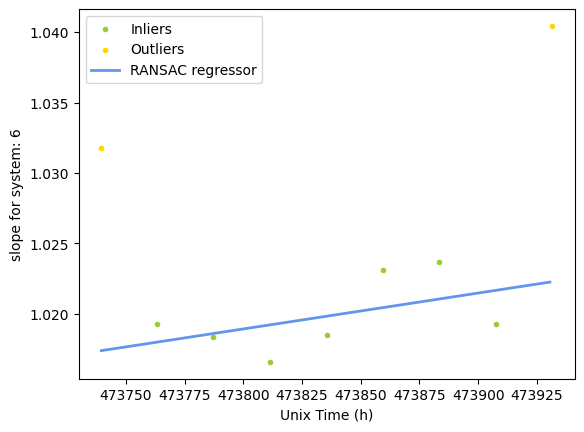

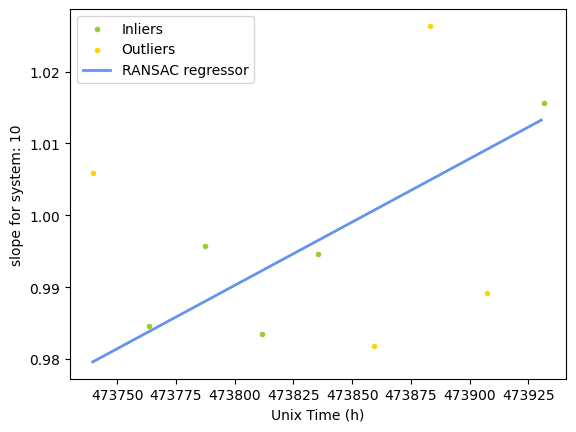

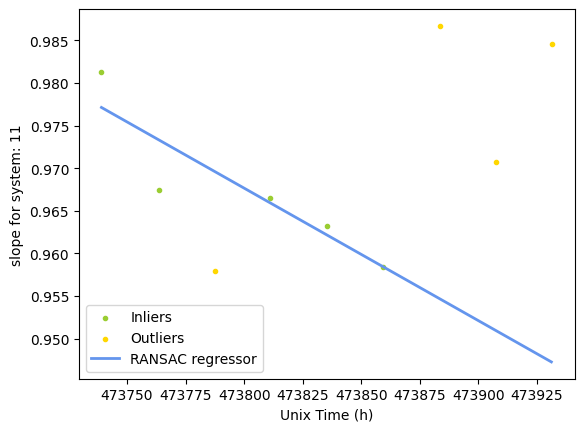

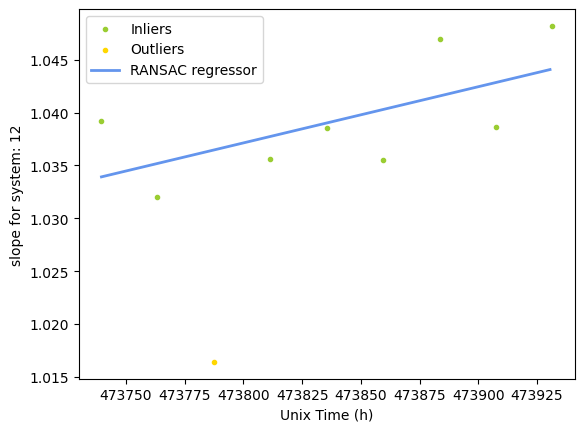

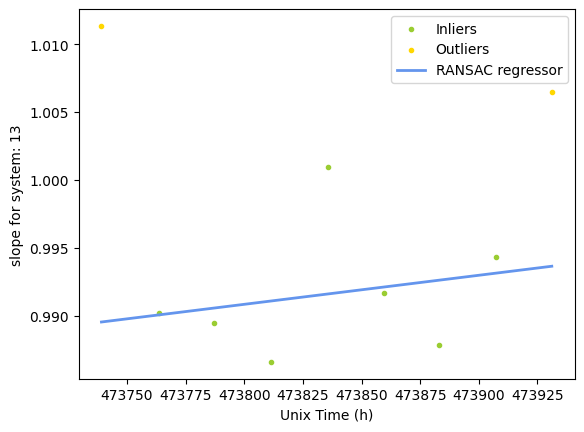

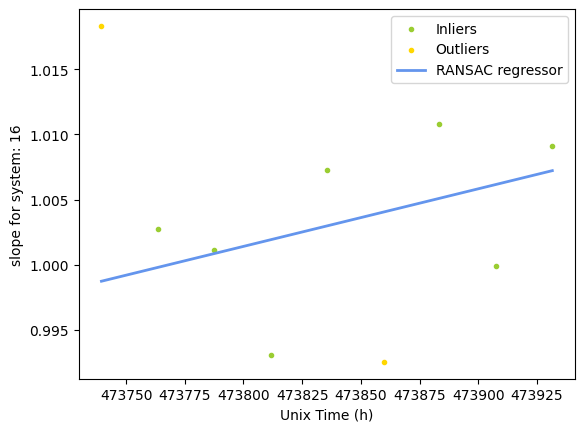

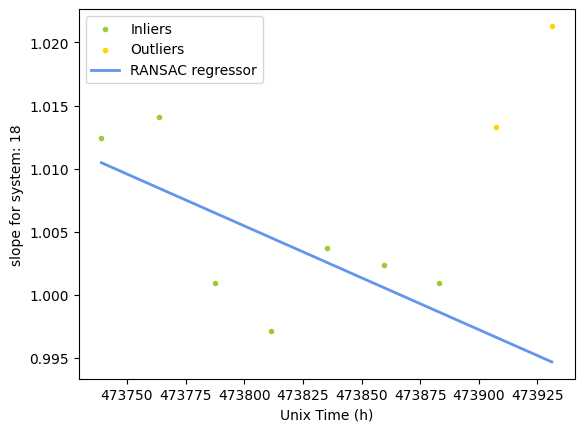

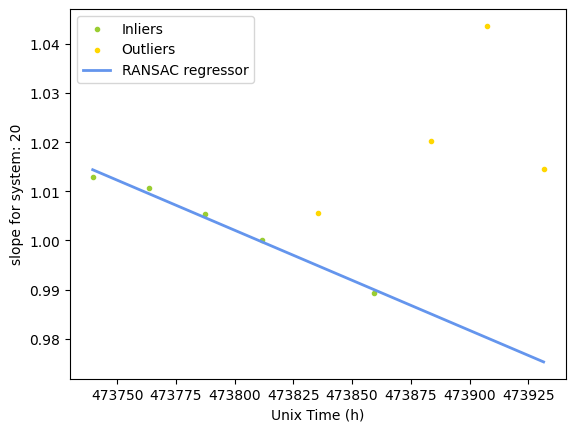

In [17]:
l_df_cor = []

for id in system_ids:
    try:
        df_sys = df_cal.filter(pl.col("system_name") == f"tum-esm-midcost-raspi-{id}").filter(pl.col("creation_timestamp").is_between(start_date, end_date))

        y = df_sys.select(pl.col("slope")).collect().to_series().to_list()
        x = df_sys.select(pl.col("timestamp")).collect().to_series().to_list()
        d = df_sys.select(pl.col("creation_timestamp")).collect().to_series().to_list()
        mask = fit_ransac(x,y,d)

        df_sys = df_sys.with_columns(mask = pl.Series(mask)).collect()
        
        l_df_cor.append(df_sys)
    except Exception as e:
        print(e)
        print(f"Could not find calibrations for system {id}")
    

df_cal_ransac = pl.concat(l_df_cor, how="diagonal")

In [7]:
df_cal_ransac = df_cal_ransac.with_columns((pl.col("slope") * pl.col("mask")).alias("ransac_slope")) \
    .with_columns((pl.col("intercept") * pl.col("mask")).alias("ransac_intercept")) \
    .filter(pl.col("mask") == True) \
    .sort("creation_timestamp") \
    .lazy()
    
df_cal_ransac.head(3).collect()

date,system_name,slope,intercept,creation_timestamp,timestamp,mask,ransac_slope,ransac_intercept
date,str,f64,f64,"datetime[μs, UTC]",f64,bool,f64,f64
2024-01-17,"""tum-esm-midcos…",1.031741,-1.2621,2024-01-17 03:31:32.210 UTC,473739.525614,true,1.031741,-1.2621
2024-01-17,"""tum-esm-midcos…",1.012885,-15.632625,2024-01-17 03:31:55.320 UTC,473739.532033,true,1.012885,-15.632625
2024-01-17,"""tum-esm-midcos…",1.039244,1.409429,2024-01-17 03:32:04.600 UTC,473739.534611,true,1.039244,1.409429


In [8]:
df_dry = pl.scan_parquet(os.path.join(DATA_DIRECTORY, "processed", "acropolis_dry.parquet")).filter(pl.col("creation_timestamp").is_between(start_date, end_date))

In [9]:
df_dry.head(1).collect()

creation_timestamp,system_name,h2o_ah,h2o_ppm,gmp343_dry
"datetime[μs, UTC]",str,f64,f64,f64
2024-01-17 00:00:00 UTC,"""tum-esm-midcos…",3.044242,0.460377,564.398358


In [10]:
df_p_1h = pl.read_parquet(os.path.join(DATA_DIRECTORY,"processed", "1h_cal_corr_picarro.parquet")) \
        .filter(pl.col("creation_timestamp").is_between(start_date, end_date))

# reduce timestamp to date DD.XX.YYYY for measurement dataset and join slope and intercept from df_cal
df_date = df_dry.filter(pl.col("gmp343_dry") > 0) \
    .with_columns(pl.col("creation_timestamp").dt.date().alias("date")) \
    .join(df_cal_ransac, on = ["date","system_name"], how= "left")

        
l_df_cal_corr =[df_p_1h]

for id in system_ids:  
    # broadcast: via backward and forward fill
    # calibration correction: via coloumn operation 
    # aggregation: defined by filter
    # offset calculation to reference instrument PICARRO
    df_cal_corr = df_date.filter(pl.col("system_name") == f"tum-esm-midcost-raspi-{id}") \
    .fill_null(strategy = "backward") \
    .fill_null(strategy = "forward") \
    .with_columns(((pl.col("gmp343_dry")) * pl.col("slope") + pl.col("intercept")) \
    .alias("CO2_corr")) \
    .sort("creation_timestamp") \
    .groupby_dynamic("creation_timestamp", every='1h')  \
    .agg([
        pl.all().exclude(["creation_timestamp","system_name"]).mean(),
        pl.col("system_name")
        ]) \
    .with_columns(pl.col("system_name").list.last()) \
    .collect()
        
    df_cal_corr = df_cal_corr.join(df_p_1h.select("creation_timestamp", "CO2_corr") \
                .rename({"CO2_corr": "temp"}), on="creation_timestamp", how= "left") \
                .with_columns((pl.col("CO2_corr") - pl.col("temp")).alias("diff")) \
                .drop("temp")
        
    l_df_cal_corr.append(df_cal_corr)
        
    
df_cal_corr_agg_1h = pl.concat(l_df_cal_corr, how="diagonal")
df_cal_corr_agg_1h.write_parquet(os.path.join(DATA_DIRECTORY, "processed", "1h_cal_corr_acropolis.parquet"))


In [11]:
df_cal_corr_agg_1h.head(1)

creation_timestamp,CO2_corr,h2o_reported,slope,intercept,system_name,diff,h2o_ah,h2o_ppm,gmp343_dry,date,creation_timestamp_right,timestamp,mask,ransac_slope,ransac_intercept
"datetime[μs, UTC]",f64,f64,f64,f64,str,f64,f64,f64,f64,date,"datetime[μs, UTC]",f64,f64,f64,f64
2024-01-17 00:00:00 UTC,466.209114,0.493471,1.006043,0.093055,"""Picarro""",0.0,null,null,null,null,null,null,null,null,null


In [12]:
df_p_10m = pl.read_parquet(os.path.join(DATA_DIRECTORY,"processed", "10m_cal_corr_picarro.parquet")) \
        .filter(pl.col("creation_timestamp").is_between(start_date, end_date)) \
        .rename({"h2o_reported": "h2o_ppm"})

# reduce timestamp to date DD.XX.YYYY for measurement dataset and join slope and intercept from df_cal
df_date = df_dry.filter(pl.col("gmp343_dry") > 0) \
    .with_columns(pl.col("creation_timestamp").dt.date().alias("date")) \
    .join(df_cal_ransac, on = ["date","system_name"], how= "left")

        
l_df_cal_corr =[df_p_10m]

for id in system_ids:  
    # broadcast: via backward and forward fill
    # calibration correction: via coloumn operation 
    # aggregation: defined by filter
    # offset calculation to reference instrument PICARRO
    df_cal_corr = df_date.filter(pl.col("system_name") == f"tum-esm-midcost-raspi-{id}") \
    .fill_null(strategy = "forward") \
    .fill_null(strategy = "backward") \
    .with_columns(((pl.col("gmp343_dry")) * pl.col("slope") + pl.col("intercept")) \
    .alias("CO2_corr")) \
    .sort("creation_timestamp") \
    .groupby_dynamic("creation_timestamp", every='10m')  \
    .agg([
        pl.all().exclude(["creation_timestamp","system_name"]).mean(),
        pl.col("system_name")
        ]) \
    .with_columns(pl.col("system_name").list.last()) \
    .collect()
        
    df_cal_corr = df_cal_corr.join(df_p_10m.select("creation_timestamp", "CO2_corr") \
                .rename({"CO2_corr": "temp"}), on="creation_timestamp", how= "left") \
                .with_columns((pl.col("CO2_corr") - pl.col("temp")).alias("diff")) \
                .drop("temp")
        
    l_df_cal_corr.append(df_cal_corr)
        
    
df_cal_corr_agg_10m = pl.concat(l_df_cal_corr, how="diagonal")
df_cal_corr_agg_10m.write_parquet(os.path.join(DATA_DIRECTORY, "processed", "10m_cal_corr_acropolis.parquet"))


In [13]:
import plotly.express as px

#dataframe = df_cal_corr_agg_1h
dataframe = df_cal_corr_agg_10m

fig = px.line(dataframe, x="creation_timestamp", y=f"CO2_corr", markers=True, title = "CO2 Dry", color="system_name")
fig.show()

fig = px.line(dataframe, x="creation_timestamp", y=f"diff", markers=True, title = "Difference Acropolis System - PICARRO", color="system_name")
fig.show()

fig = px.line(dataframe, x="creation_timestamp", y=f"h2o_ppm", markers=True, title = "Absolute Humidity (Picarro in ppm)", color="system_name")
fig.show()

In [14]:
titles = []
for system_id in system_ids:
    titles.append(f"System: {system_id}")

fig = make_subplots(rows=3, cols=3, shared_yaxes='all', subplot_titles=(titles), x_title="ACROPOLIS (ppm)", y_title="Picarro (ppm)")
fig2 = make_subplots(rows=3, cols=3, shared_yaxes='all',  subplot_titles=(titles), x_title="ACROPOLIS (ppm)", y_title="Picarro (ppm)")
row = 1
col = 0

for system_id in system_ids:
    
    col += 1
    
    if col == 4:
        col = 1
        row += 1

    print(f"\nAnalysis for System {system_id}:")

    #----
    df_acropolis = dataframe.filter(pl.col("system_name")==f"tum-esm-midcost-raspi-{system_id}") \
        .select(["creation_timestamp", "CO2_corr", "h2o_ppm"]) \
        .rename({"CO2_corr": f"CO2_acropolis_{system_id}"}) \
        .rename({"h2o_ppm": f"H2O_acropolis_{system_id}"})
        
    df_picarro = dataframe.filter(pl.col("system_name")=="Picarro") \
        .select(["creation_timestamp", "CO2_corr","h2o_ppm"]) \
        .rename({"CO2_corr": f"CO2_picarro"}) \
        .rename({"h2o_ppm": f"H2O_picarro"})
        
    df_analysis = df_picarro.join(df_acropolis, on="creation_timestamp")  \
        .filter(pl.col("CO2_picarro") > 0)  \
        .filter(pl.col(f"CO2_acropolis_{system_id}") > 0)
        
    l_picarro = df_analysis.select("CO2_picarro").to_series().to_list()
    l_picarro_h2o = df_analysis.select("H2O_picarro").to_series().to_list()
    l_acropolis = df_analysis.select(f"CO2_acropolis_{system_id}").to_series().to_list()
    l_acropolis_h2o = df_analysis.select(f"H2O_acropolis_{system_id}").to_series().to_list()
    
    #----
    if len(l_acropolis) > 0:
        
        #plotly scatterplot
        fig.add_trace(go.Scatter(x=l_acropolis, y=l_picarro, name = f"MC-{system_id}", mode='markers'),row=row, col=col) 
        fig2.add_trace(go.Scatter(x=l_acropolis_h2o, y=l_picarro_h2o,  name = f"MC-{system_id}", mode='markers'),row=row, col=col)
        
        mean_offset = df_cal_corr_agg_1h.filter(pl.col("system_name")==f"tum-esm-midcost-raspi-{system_id}").select("diff").mean().item()
        #print(f"Offset {mean_offset}")
        
        rmse_result = rmse(l_picarro,l_acropolis)
        #print(f"RMSE: {rmse_result}")
        
        r2_result = calc_r2(l_picarro,l_acropolis)
        #print(f"R2: {r2_result}")
        
        print(f"Offset {mean_offset}, RMSE: {rmse_result}, R2: {r2_result}")
   
fig.update_layout(title_text="Scatter Plots: CO2 (dry)", height=1000, width=1000, showlegend=False)
#fig.update_layout(xaxis=dict(tickmode='linear',tick0=10,dtick=10), yaxis=dict(tickmode='linear',tick0=10,dtick=10))     
fig.show()
fig2.update_layout(title_text="Scatter Plots: Water Vaport (ppm)", height=1000, width=1000, showlegend=False)
#fig2.update_layout(xaxis=dict(tickmode='linear',tick0=0.25,dtick=0.25), yaxis=dict(tickmode='linear',tick0=0.25,dtick=0.25))    
fig2.show()


Analysis for System 3:
Offset -0.42365902108551534, RMSE: 1.3033531852374496, R2: 0.9860952704297935

Analysis for System 6:
Offset -0.03405005629546354, RMSE: 2.6488277864988725, R2: 0.9425780898341805

Analysis for System 10:
Offset -1.136653428807242, RMSE: 1.6163611486983052, R2: 0.9785908145008068

Analysis for System 11:
Offset 0.08507975791565814, RMSE: 1.1788843817219876, R2: 0.9886115199050386

Analysis for System 12:
Offset -0.4756105648280804, RMSE: 1.1398331612403763, R2: 0.9893535231394164

Analysis for System 13:
Offset 0.23083429865815486, RMSE: 1.1429914731103237, R2: 0.9892944417225353

Analysis for System 16:
Offset 0.20553138476744648, RMSE: 0.980951275461455, R2: 0.9921016988750937

Analysis for System 18:
Offset -0.40770887372759956, RMSE: 0.8538298644309457, R2: 0.9940259889566505

Analysis for System 20:
Offset -0.39454141755060235, RMSE: 1.21579199891779, R2: 0.9878872737852776


# Substract mean offset

In [15]:
for system_id in system_ids:

    print(f"\nAnalysis for System {system_id}:")

    #----
    mean_offset = 0
    if len(l_acropolis) > 0:
        mean_offset = df_cal_corr_agg_1h.filter(pl.col("system_name")==f"tum-esm-midcost-raspi-{system_id}").select("diff").mean().item()
    
    df_acropolis = df_cal_corr_agg_1h.filter(pl.col("system_name")==f"tum-esm-midcost-raspi-{system_id}") \
        .select(["creation_timestamp", "CO2_corr"]) \
        .with_columns(pl.col("CO2_corr") - mean_offset)  \
        .rename({"CO2_corr": f"CO2_acropolis_{system_id}"})
        
    df_picarro = df_cal_corr_agg_1h.filter(pl.col("system_name")=="Picarro") \
        .select(["creation_timestamp", "CO2_corr"]) \
        .rename({"CO2_corr": f"CO2_picarro"})
        
    df_analysis = df_picarro.join(df_acropolis, on="creation_timestamp")  \
        .filter(pl.col("CO2_picarro") > 0)  \
        .filter(pl.col(f"CO2_acropolis_{system_id}") > 0)
        
    l_picarro = df_analysis.select("CO2_picarro").to_series().to_list()
    l_acropolis = df_analysis.select(f"CO2_acropolis_{system_id}").to_series().to_list()
    
    #----
    if len(l_acropolis) > 0:
        
        rmse_result = rmse(l_picarro,l_acropolis)
        #print(f"RMSE: {rmse_result}")
        
        r2_result = calc_r2(l_picarro,l_acropolis)
        #print(f"R2: {r2_result}")
        
        print(f"RMSE: {rmse_result}, R2: {r2_result}")


Analysis for System 3:
RMSE: 0.9770488001159201, R2: 0.9913142505695887

Analysis for System 6:
RMSE: 1.6933315028960632, R2: 0.9739109201930888

Analysis for System 10:
RMSE: 0.9689723832146004, R2: 0.9914572522291213

Analysis for System 11:
RMSE: 1.1250180190692556, R2: 0.9884842098556454

Analysis for System 12:
RMSE: 0.6814969881210424, R2: 0.9957742610286232

Analysis for System 13:
RMSE: 0.8991793026681144, R2: 0.9926435652275784

Analysis for System 16:
RMSE: 0.8492475905677186, R2: 0.9934378911225602

Analysis for System 18:
RMSE: 0.6608310631698361, R2: 0.9960266604174358

Analysis for System 20:
RMSE: 0.8424817292104947, R2: 0.9935420338039783


# Enclosure Temperature Control

In [16]:
(data['air_temperature_2m']-273.15).resample('1h').mean().plot()

NameError: name 'data' is not defined

ValueError: Length of values (120) does not match length of index (37131)